In [1]:
import os 

In [2]:
from langchain_core.tools import tool
import PyPDF2
import re
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
import smtplib
from email.message import EmailMessage
import os
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer, util

d:\anaconda\envs\hr_agent\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
@tool
def extract_text_from_pdf(pdf_path: str) -> dict:
    """Extract text and email address from a PDF resume."""
    try:
        with open(pdf_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            text = ""
            for page in reader.pages:
                text += page.extract_text() or ""  # Handle NoneType

        email_match = re.search(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", text)
        email = email_match.group(0) if email_match else ""

        return {"resume_text": text, "email": email}

    except Exception as e:
        print("Error extracting text from PDF:", e)  # Log the error
        return {"resume_text": "", "email": ""}

In [4]:
model = SentenceTransformer('all-MiniLM-L6-v2')

@tool
def llm_ats_score(resume_text: str, job_text: str) -> dict:
    """
    Compute semantic similarity between resume and job description using embeddings.
    Returns an ATS score between 0–100.
    """
    try:
        embeddings = model.encode([resume_text, job_text])
        similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
        score = round(similarity * 100, 2)
        return {"ats_score": score}
    except Exception as e:
        print("❌ Semantic scoring failed:", e)
        return {"ats_score": 0.0}

load_dotenv()
# sender = os.getenv("EMAIL_SENDER") # These might not be needed globally if used inside the tool
# password = os.getenv("EMAIL_PASSWORD") # as they are loaded inside send_rejection_email

@tool
def send_rejection_email(email: str) -> dict:
    """Send a polite rejection email if ATS score is low."""
    sender = os.getenv("EMAIL_SENDER")
    password = os.getenv("EMAIL_PASSWORD")

    try:
        msg = EmailMessage()
        msg["Subject"] = "Regarding Your Job Application"
        msg["From"] = sender
        msg["To"] = email
        msg.set_content("Thank you for your application. Please feel free to reapply in the future. Best wishes!")

        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
            server.login(sender, password)
            server.send_message(msg)

        return {"email_sent": True}
    except Exception as e:
        print("Error sending rejection email:", e)  # Log the error
        return {"email_sent": False}

In [5]:
class HRApplicationState(TypedDict):
    pdf_path: str
    resume_text: str
    email: str
    job_text: str # Add a default or ensure it's provided
    ats_score: float

In [6]:
workflow = StateGraph(HRApplicationState)

# Define the first node as a regular function, not a ToolNode initially,
# if it's meant to directly process the input state.
def _extract_resume_node(state: HRApplicationState) -> HRApplicationState:
    pdf_path = state["pdf_path"]
    extracted_data = extract_text_from_pdf.invoke({"pdf_path": pdf_path}) # Call the tool function directly
    return {"resume_text": extracted_data["resume_text"], "email": extracted_data["email"]}

# The ATS scorer still needs the resume_text and job_text
# It's better to ensure job_text is always present in the initial state,
# or add another node to get it. For this example, let's assume it's in the initial state.
def _ats_scorer_node(state: HRApplicationState) -> HRApplicationState:
    # Ensure job_text is present before calling the tool
    if not state.get("job_text"):
        print("Error: 'job_text' is missing in the state for ATS scoring.")
        return {"ats_score": 0.0} # Or raise an error
    
    score_data = llm_ats_score.invoke({
        "resume_text": state["resume_text"],
        "job_text": state["job_text"]
    })
    return {"ats_score": score_data["ats_score"]}

# The email sender also needs the email
def _send_rejection_node(state: HRApplicationState) -> HRApplicationState:
    if state["ats_score"] < 70:
        email_sent_data = send_rejection_email.invoke({"email": state["email"]})
        return email_sent_data
    return {} # No update if email not sent


In [7]:
# Add nodes as callables
workflow.add_node("extract_resume", _extract_resume_node)
workflow.add_node("ats_scorer", _ats_scorer_node)
workflow.add_node("send_rejection", _send_rejection_node) # Changed this to a normal function too

workflow.set_entry_point("extract_resume")
workflow.add_edge("extract_resume", "ats_scorer")

def decide_next(state: HRApplicationState) -> str:
    # Ensure ats_score is set before comparison
    if state.get("ats_score") is None:
        # Handle case where ats_score might not have been computed or is missing
        print("ATS score not found, defaulting to rejection path.")
        return "send_rejection" 
    return "send_rejection" if state["ats_score"] < 70 else END

workflow.add_conditional_edges("ats_scorer", decide_next, {
    "send_rejection": "send_rejection",
    END: END,
})
workflow.add_edge("send_rejection", END)

app = workflow.compile()


In [8]:
import langgraph

graph = app.get_graph()
print(graph)

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'extract_resume': Node(id='extract_resume', name='extract_resume', data=extract_resume(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'ats_scorer': Node(id='ats_scorer', name='ats_scorer', data=ats_scorer(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'send_rejection': Node(id='send_rejection', name='send_rejection', data=send_rejection(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='extract_resume', data=None, conditional=False), Edge(source='ats_scorer', target='__end__', data=None, conditional=True), Edge(sou

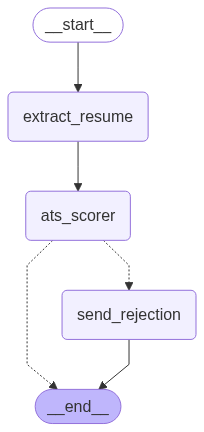

In [9]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
pdf_path = "new_resume.pdf" # Make sure this PDF exists in your environment
job_description_text = "We are looking for a software engineer with strong Python skills and experience in machine learning." # Provide a job description

state = {
    'pdf_path': pdf_path,
    'job_text': job_description_text, # Add job_text to the initial state
    'resume_text': '', # Initialize
    'email': '', # Initialize
    'ats_score': 0.0 # Initialize
}


In [11]:
result = app.invoke(state)
print("Final State:", result)

Final State: {'pdf_path': 'new_resume.pdf', 'resume_text': 'Lingeswaran Mithurshan\nlingeswaranmithurshan222@gmail.com |+94 75 349 8492 |Batticaloa, Sri Lanka\ngithub.com/ldotmithu |linkedin.com/in/lingeswaran\nSkills\n•Programming : Python, SQL, JavaScript, HTML\n•AI/ML Tools : Scikit-learn, TensorFlow, Keras, XGBoost,\nHugging Face, Groq API, LangChain\n•Web & Deployment : Streamlit, Flask, Docker, Git, AWS\n•Data : Pandas, NumPy, Power BI, Seaborn, Matplotlib,\nFAISS, Apify SDK\n•Core Areas : Machine Learning, NLP, Computer Vision,\nLLMs, Model Deployment\nEducation\nB.Sc. Management Studies and Commerce 02/2023 –\n12/2026\nUniversity of Sri Jayewardenepura, Sri Lanka\nCertiﬁed Data Scientist (IIT-M) 12/2024 – 08/2025\nGUVI, Online\nProfessional Summary\nResults-driven AI/ML Engineer with expertise in Machine\nLearning, Deep Learning, and Generative AI, seeking an\nentry-level AI or Data Science role. Proﬁcient in develop-\ning production-ready solutions using Python, TensorFlow, an

In [12]:
print(result)

{'pdf_path': 'new_resume.pdf', 'resume_text': 'Lingeswaran Mithurshan\nlingeswaranmithurshan222@gmail.com |+94 75 349 8492 |Batticaloa, Sri Lanka\ngithub.com/ldotmithu |linkedin.com/in/lingeswaran\nSkills\n•Programming : Python, SQL, JavaScript, HTML\n•AI/ML Tools : Scikit-learn, TensorFlow, Keras, XGBoost,\nHugging Face, Groq API, LangChain\n•Web & Deployment : Streamlit, Flask, Docker, Git, AWS\n•Data : Pandas, NumPy, Power BI, Seaborn, Matplotlib,\nFAISS, Apify SDK\n•Core Areas : Machine Learning, NLP, Computer Vision,\nLLMs, Model Deployment\nEducation\nB.Sc. Management Studies and Commerce 02/2023 –\n12/2026\nUniversity of Sri Jayewardenepura, Sri Lanka\nCertiﬁed Data Scientist (IIT-M) 12/2024 – 08/2025\nGUVI, Online\nProfessional Summary\nResults-driven AI/ML Engineer with expertise in Machine\nLearning, Deep Learning, and Generative AI, seeking an\nentry-level AI or Data Science role. Proﬁcient in develop-\ning production-ready solutions using Python, TensorFlow, and\nLangChain,